# Ship Speed Estimate

This guide runs through buildings, training and evaluating the model for estimating ship speed. In the guide we will be using [Single Ground Based AIS Receiver Vessel Tracking Dataset](https://zenodo.org/records/3754481) dataset collected from [AIS](https://en.wikipedia.org/wiki/Automatic_identification_system) (Automatic Identification System). The dataset is comprised of 371585 data points representing coordinates of a vessel, heading, course, vessel type and it's speed.

In [1]:
!pip install matplotlib osmnx geopandas torchmetrics -qqq

## Defining the Dataset

In order to use the data for training a neural network, we need to define a dataset class, that should inherit from the standard [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), and implement `__len__` and `__getitem__`.

Since the dataset is relatively small, we could simply download it into memory and then parse CSV file to turn it into the Pandas `DataFrame`. In this quite artificial task, the goal would be estimation of the speed of a moving vessel, therefore final dataset won't contain rows with zero speed.

In [2]:
import urllib.request
from io import BytesIO
from zipfile import ZipFile

import pandas as pd

DOWNLOAD_URL = "https://zenodo.org/records/3754481/files/INFORE_AIS_dataset.zip?download=1"


with urllib.request.urlopen(DOWNLOAD_URL) as url:
    archive = url.read()

with ZipFile(BytesIO(archive)) as zf:
    with zf.open("INFORE_AIS_dataset/ais.csv") as ais_file:
        dataset = pd.read_csv(ais_file)


dataset = dataset[dataset["speed"] >= 2.0]

# Filter locations that are recorded too far away. There might be more sophisticated
# ways of filtering out inaccurate GPS coordinates, but for this example, this would
# be sufficient.
dataset = dataset[(dataset["lon"] > 20) & (dataset["lon"] < 25.0)]
dataset = dataset[dataset["lat"] > 20]
dataset.reset_index(drop=True, inplace=True)
dataset.head()

,t,shipid,lon,lat,heading,course,speed,shiptype,destination
0,2020-02-29T22:00:04Z,a0d881e0-d774-4f2d-b2ad-23014b794aac,23.519545,37.828400,110.0,110.3,15.8,80.0,CARTAGENA
1,2020-02-29T22:00:05Z,e979ac5d-365b-4fa9-84e2-b6753ebc3089,23.602137,37.955218,156.0,169.0,9.9,52.0,PIRAEUS
2,2020-02-29T22:00:06Z,08af8eb0-dc60-45f9-96b0-e5ee3c95aa4a,23.609950,37.877983,NaN,167.3,9.3,30.0,NaN
3,2020-02-29T22:00:06Z,6cf361f0-c551-4c8a-8922-3d11b7ae4b95,23.569200,37.957683,NaN,70.0,9.2,52.0,PERAMA
4,2020-02-29T22:00:07Z,e979ac5d-365b-4fa9-84e2-b6753ebc3089,23.602185,37.955082,152.0,160.4,9.8,52.0,PIRAEUS


To simplify this example, we will predict the speed of only single ship type (the most frequent one).

In [3]:
ship_freq = dataset.groupby("shiptype").agg(count=("shipid", "count"))
ship_type = ship_freq.nlargest(1, columns="count").index[0]

dataset = dataset[dataset["shiptype"] == ship_type].reset_index(drop=False)

Below you can see sample of dataset, or coordinates of ship traversals depicted as black dots. Blue lines in the picture represent coastlines from the [Open Street Map](https://openstreetmap.org).

In [4]:
import osmnx as ox


lon_min = dataset["lon"].min()
lon_max = dataset["lon"].max()
lat_min = dataset["lat"].min()
lat_max = dataset["lat"].max()

bounding_box = (lat_max, lat_min, lon_max, lon_min)
coastlines = ox.features_from_bbox(bbox=bounding_box, tags={"natural": "coastline"})

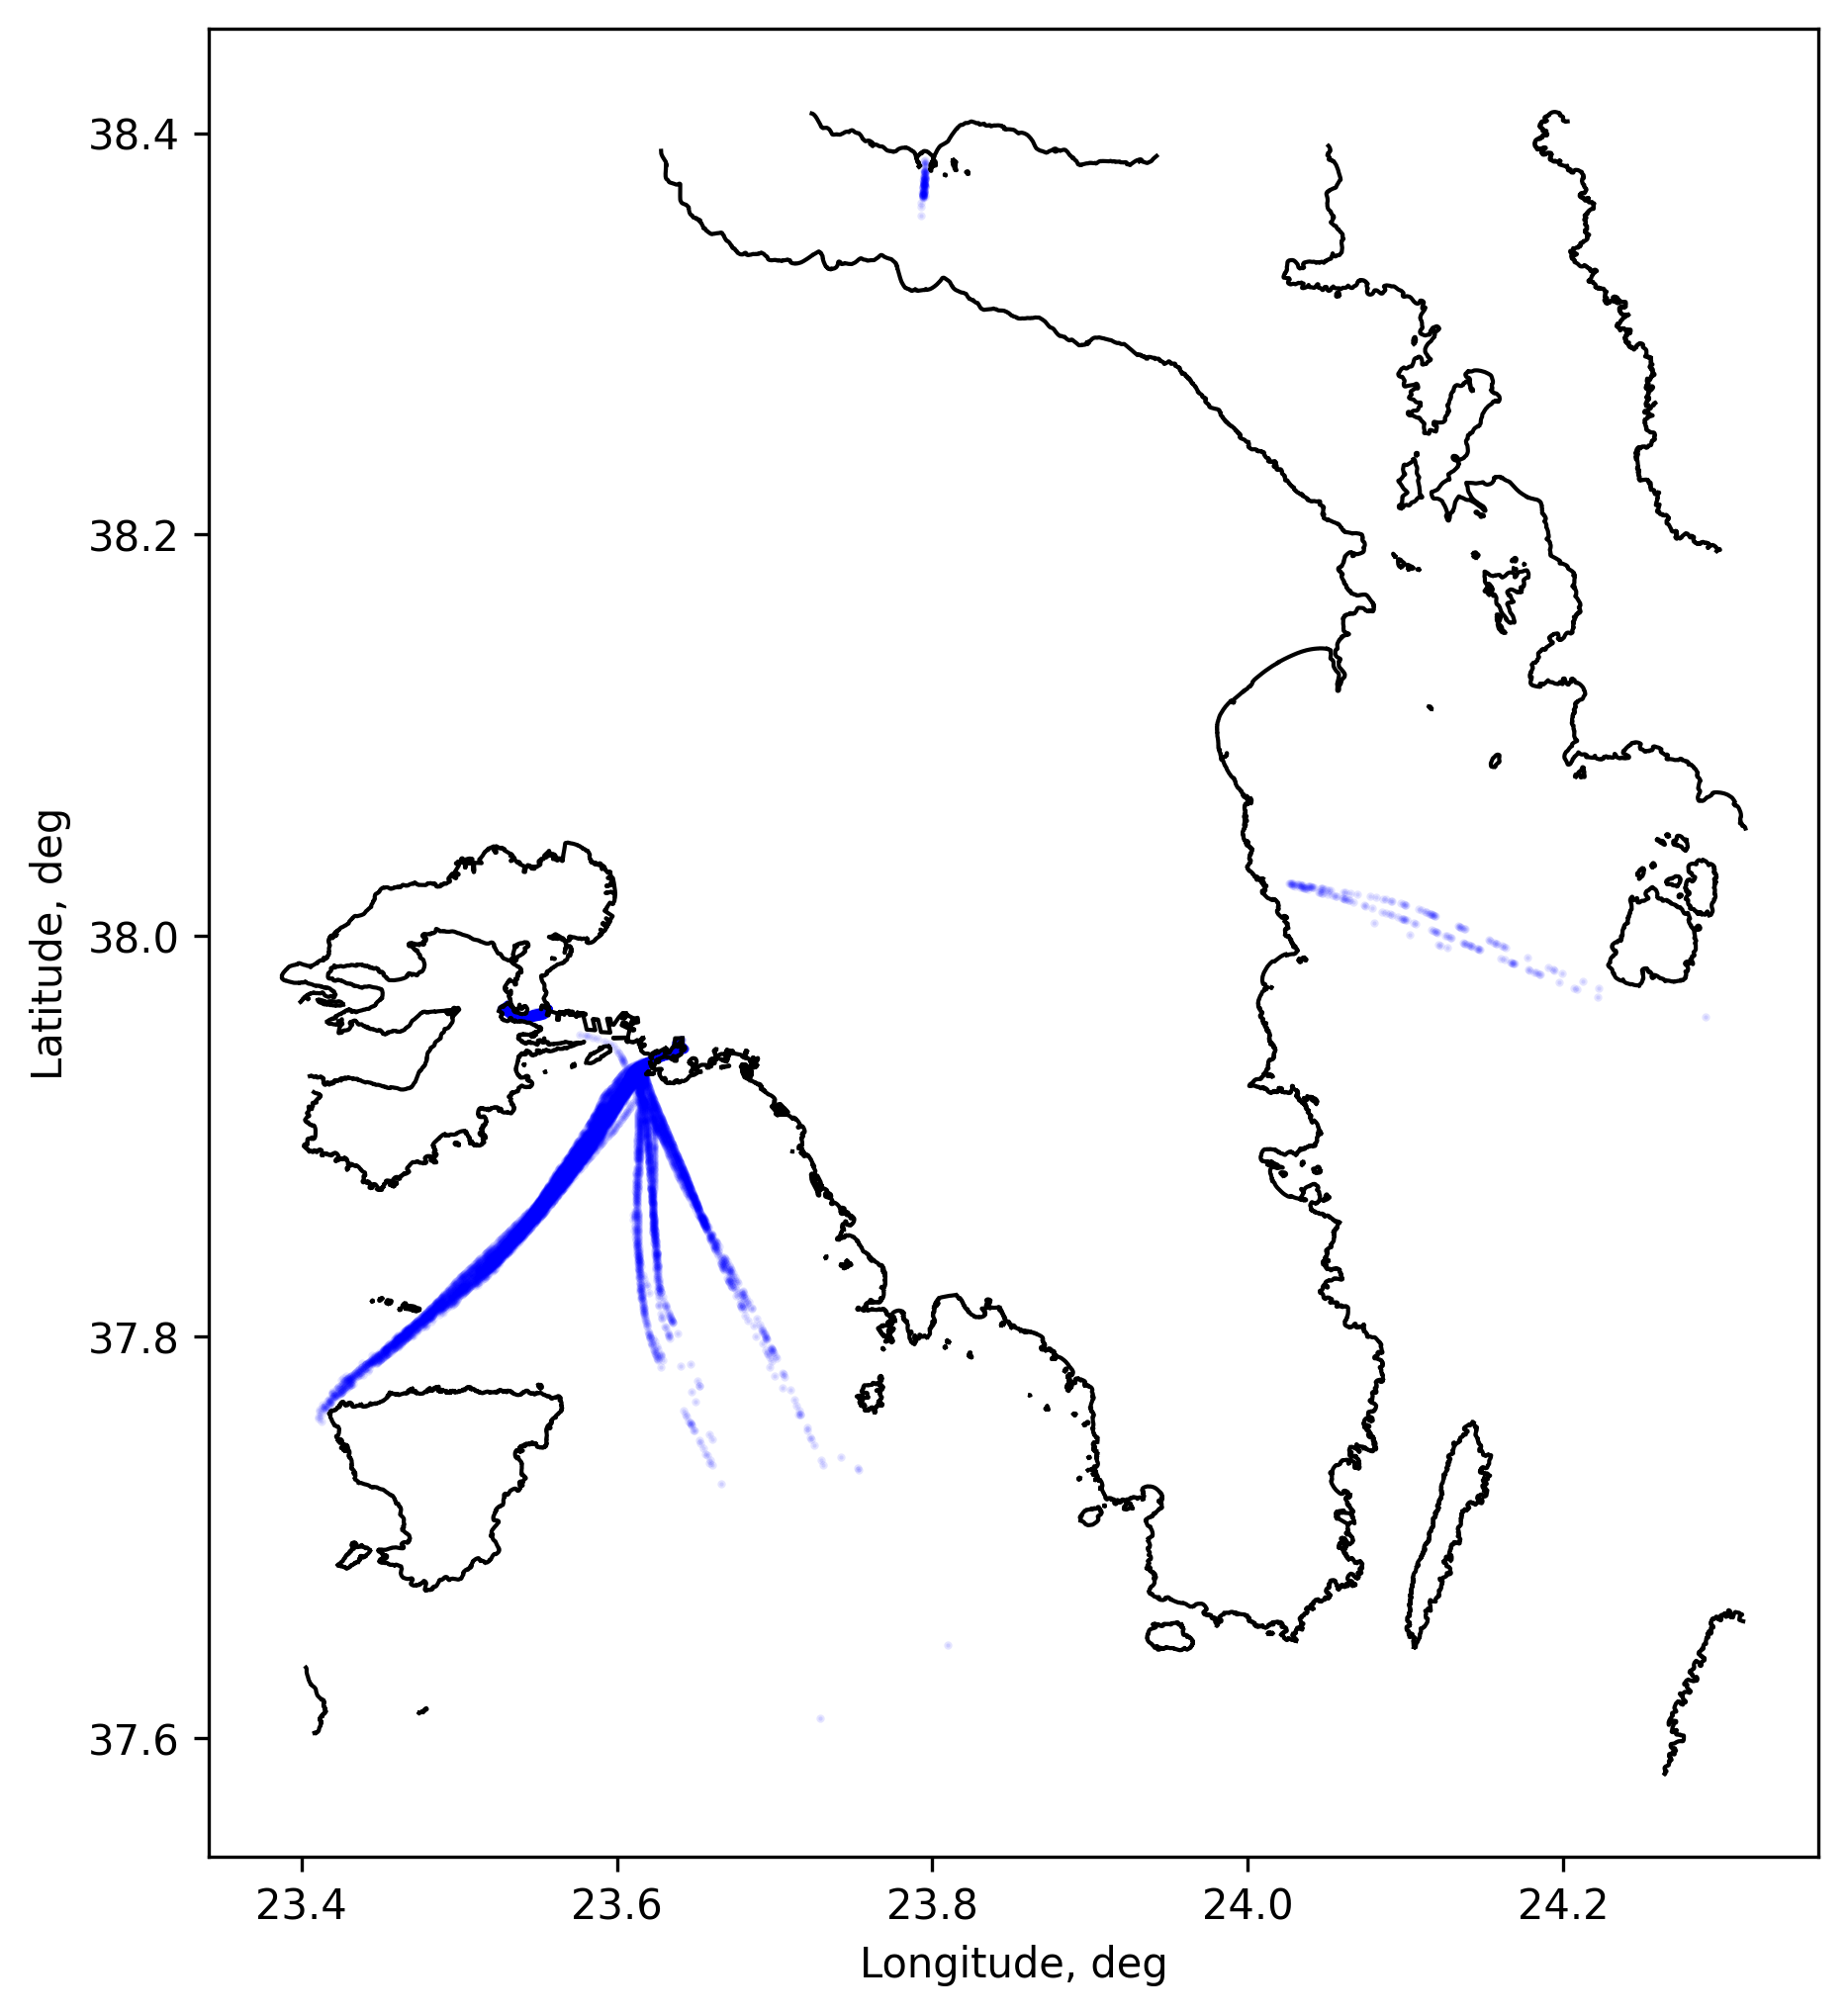

In [5]:
from matplotlib import pyplot as plot
from shapely import Polygon, LineString

fig, ax = plot.subplots()
fig.set_dpi(300)
fig.set_size_inches(7, 8)

ax.set_xlabel("Longitude, deg")
ax.set_ylabel("Latitude, deg")
ax.scatter(dataset["lon"][::1], dataset["lat"][::1], s=1, color="blue", alpha=0.1)

for coastline in coastlines.itertuples():
    if isinstance(coastline.geometry, Polygon):
        ax.plot(*coastline.geometry.exterior.xy, color="black", lw=1)
    if isinstance(coastline.geometry, LineString):
        ax.plot(*coastline.geometry.xy, color="black", lw=1)
None

On the next step we need to split dataset into training and test sub-sets, in this example we will use 80% of data for training and 20% of data for testing (evaluation) of a model.

In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, random_split


class AisDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.max_speed = df["speed"].max()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Take necessary row from the dataset and convert it to torch.Tensor.
        x = self.df.iloc[idx][["lon", "lat"]].to_numpy(dtype=np.float64)
        y = self.df.iloc[idx][["speed"]].to_numpy(dtype=np.float64) / self.max_speed
        return torch.DoubleTensor(x), torch.DoubleTensor(y)


train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

ais_dataset = AisDataset(dataset)
train_set, test_set = random_split(ais_dataset, [train_size, test_size])

## Defining Models

The model we are going to use will be compare regular quad pooling layer and adaptive quad pooling layer. Essentially, those modules build [quadtree](https://en.wikipedia.org/wiki/Quadtree) for spatial decomposition of the points. We assume that vessels within certain geographical coordinates use similar speeds, pretty much like cars when traversing through road segments.

Adaptive module allows to dynamically shape the decomposition based on density of points: regions with higher density are finer grained than regions with fewer points. Regular pooling module on the other hand, tiles the target polygon into quads of the same size.

Below we define two models `QuadNN` and `AdaptiveQuadNN` that use quad pooling operations: regular and adaptive.

In [7]:
from torch import nn
from torch_geopooling.nn import AdaptiveQuadPool2d
from torch_geopooling.nn import QuadPool2d


class QuadNN(nn.Module):

    def __init__(self, bbox):
        super().__init__()
        n, s, e, w = bbox
        self.pool = QuadPool2d(
            feature_dim=1,
            polygon=Polygon([(w, s), (e, s), (e, n), (w, n)]),
            exterior=(-180, -90, 360, 180),
            max_depth=14
        )
        self.linear = nn.Linear(1, 1, dtype=torch.float64)

    def forward(self, x):
        x = torch.clamp(self.pool(x), 0.0)
        x = self.linear(x)
        return x


class AdaptiveQuadNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.pool = AdaptiveQuadPool2d(
            feature_dim=1,
            exterior=(-180, -90, 360, 180),
            capacity=5,
            max_depth=15
        )
        self.linear = nn.Linear(1, 1, dtype=torch.float64)

    def forward(self, x):
        x = torch.clamp(self.pool(x), 0.0)
        x = self.linear(x)
        return x

## Training Models

Further we use a standard training loop and Stochastic Gradient Descent optimization algorithm to train models. Note, that adaptive pooling operations are using sparse weight tensor and therefore only a limited set of optimization algorithms could be used for training.

In [8]:
from torch.utils.data import DataLoader
from torch.optim import SGD


def train(model, lr=0.1):
    loss_fn = nn.HuberLoss()
    optimizer = SGD(model.parameters(), lr=lr)

    for epoch in range(10):
        for batch in DataLoader(train_set, batch_size=2048):
            x, y = batch
    
            optimizer.zero_grad()
            y_pred = model(x)
    
            loss = loss_fn(y, y_pred)
            loss.backward()
            optimizer.step()
    return model

In [9]:
qnn = train(QuadNN(bounding_box))
aqnn = train(AdaptiveQuadNN())

## Evaluating Models

On the final step, we evaluate models' performance and compute mean absolute error and weighted mean absolute percentage error. As you could see the from the table below, both models require improvements.

Additionally, `torch_geopooling` library provides `TileWKT` transformer that allows to inspect the model and plot quads that where learned by the model. Below are presented learned decomposition for regular and adaptive pooling operations.

In [10]:
import warnings
warnings.filterwarnings("ignore")

from torchmetrics import MeanAbsoluteError
from torchmetrics import WeightedMeanAbsolutePercentageError


def test(model):
    mae = MeanAbsoluteError()
    wmape = WeightedMeanAbsolutePercentageError()
    
    for batch in DataLoader(train_set, batch_size=len(test_set)):
        x, y_true = batch
        y_pred = model.eval()(x)
    return {
        "MAE": mae(y_true, y_pred).numpy(),
        "wMAPE": wmape(y_true, y_pred).numpy(),
    }

metrics = {}
with torch.no_grad():
    metrics["QuadNN"] = test(qnn)
    metrics["AdaptiveQuanNN"] = test(aqnn)

pd.DataFrame(metrics)

,QuadNN,AdaptiveQuanNN
MAE,0.17504837,0.183494
wMAPE,0.42560935,0.42367932


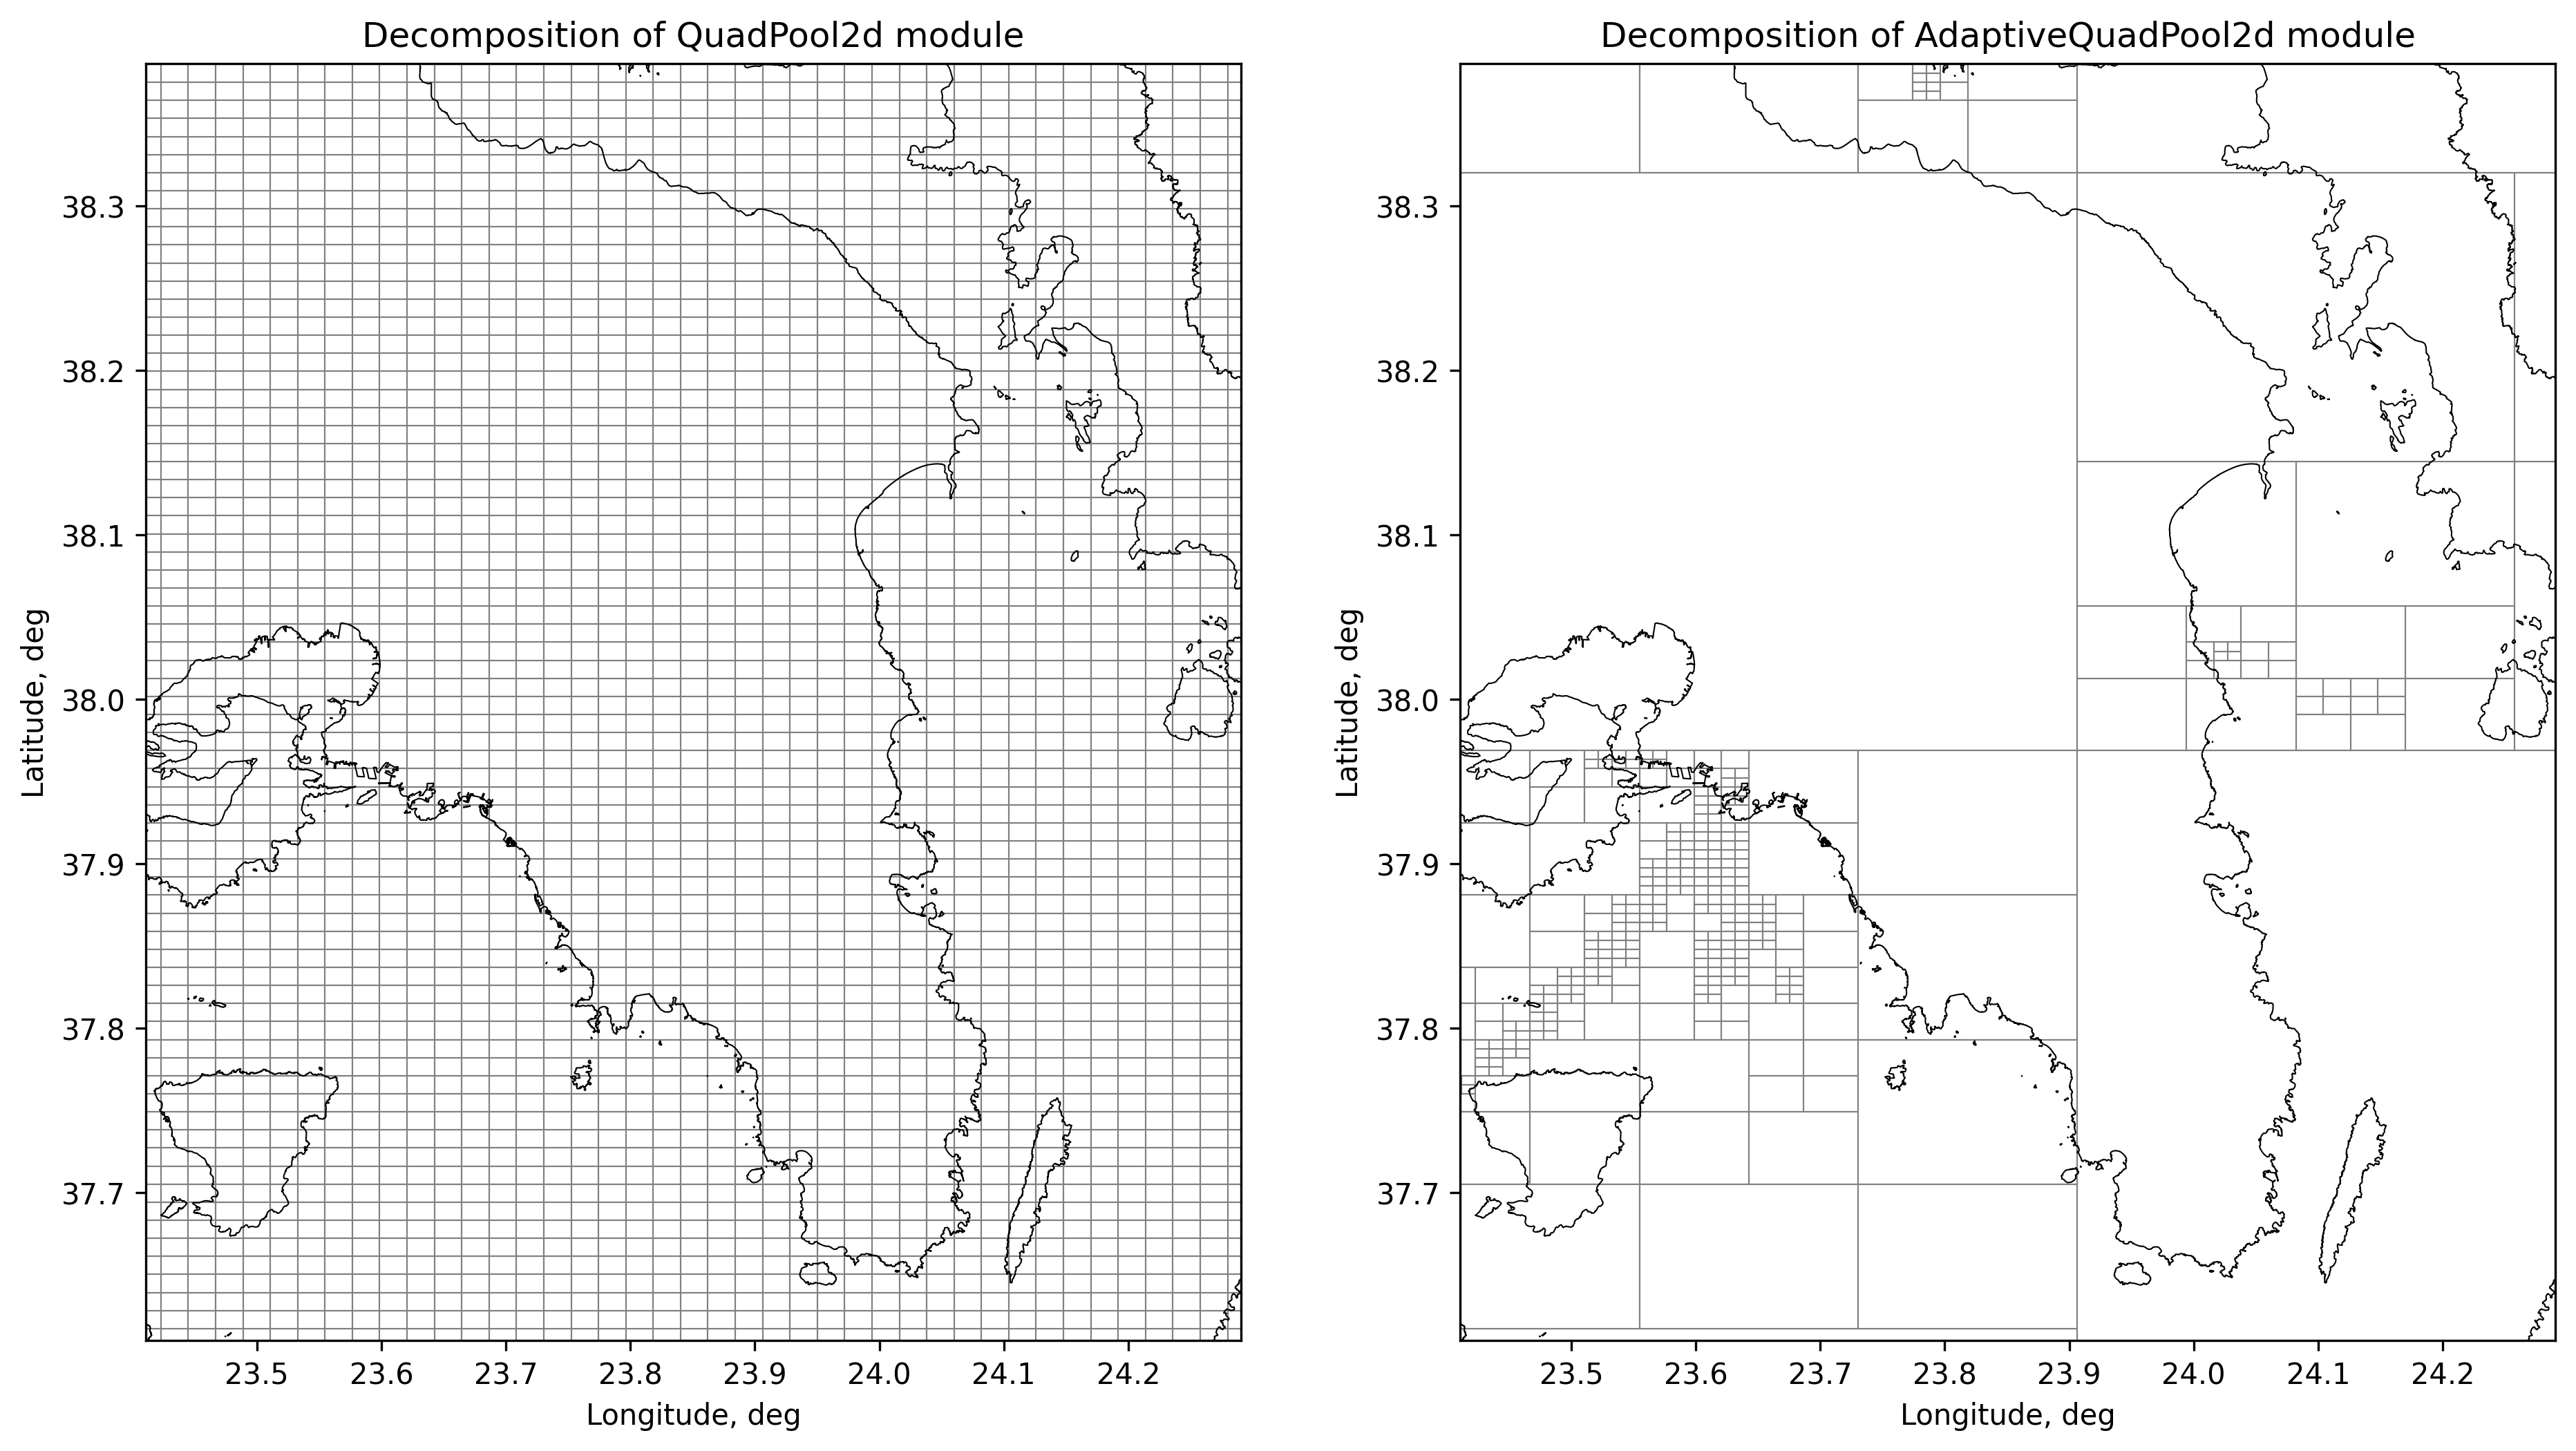

In [11]:
from torch_geopooling.transforms import TileWKT
from shapely import from_wkt


def render_tiles(ax, tiles, bbox):
    for tile in TileWKT(exterior=(-180, -90, 360, 180), internal=False)(tiles):
        ax.plot(*from_wkt(tile).exterior.xy, color="gray", lw=0.5)
    
    for coastline in coastlines.itertuples():
        if isinstance(coastline.geometry, Polygon):
            ax.plot(*coastline.geometry.exterior.xy, color="black", lw=0.5)
        if isinstance(coastline.geometry, LineString):
            ax.plot(*coastline.geometry.xy, color="black", lw=0.5)

    n, s, e, w = bbox
    ax.set_xlim(w, e)
    ax.set_ylim(s, n)
    ax.set_xlabel("Longitude, deg")
    ax.set_ylabel("Latitude, deg")


fig, ax = plot.subplots(ncols=2)
fig.set_dpi(300)
fig.set_size_inches(15, 8)

ax[0].set_title("Decomposition of QuadPool2d module")
ax[1].set_title("Decomposition of AdaptiveQuadPool2d module")

render_tiles(ax[0], qnn.pool.tiles, bounding_box)
render_tiles(ax[1], aqnn.pool.weight.coalesce().indices().t()[:,:-1], bounding_box)